# TP I : Descentes de Gradient

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations des descentes de gradients, du moins dans un premier cadre naïf. **C'est un *TP à trous* ; il s'agira de compléter ces trous pour un rendu au plus tard le dimanche 30 août 2020.**

Voici un aperçu des points abordés lors de ce TP.

- Un set de fonctions tests: comment se donne-t-on une fonction numérique? 
- Calculer le gradient d'une fonction: coder une solution en dur ou calcul approché?
- La classe GD: une classe qui sert d'interface pour toutes les descentes qu'on souhaite implémenter. 
- La Descente de Gradient :
    - Calcul du pas : pas constant, *Backtracking*
    - Choix de norme : la classique, la norme $1$
    - Sensibilité aux points initiaux
    - Sensibilité aux nombres de conditionnement
    - Accélération : Momentum, Nesterov, Adam.
- Cas d'application classique: la régression linéaire.
- La Méthode de Newton : 
    - La classe MN
    - Comparaison à la GD.
- Face aux contraintes d'égalité.


## Attendus de rendu

Vous êtes invités à compléter ce TP et à le prolonger par le travail qui vous est suggéré. Votre rendu sera jugé à l'aune de

- votre capacité à produire des algorithmes valides, répondant à la question posée
- l'étude effectuée concernant la sensibilité de vos algorithmes aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- les stress-tests auxquels vous aurez confrontés vos implémentations. 

On portera une attention particulière à la *généricité* de votre réponse ; tout comme cela vous est suggéré par la suite on attendra de vous d'appuyer vos affirmations par suffisamment de tests et une appréciation pour les limites de votre analyse.

Ce TP est à rendre par **groupes de 3** et exceptionnellement **2**. Il sera complété d'une soutenance portant sur l'ensemble des TPs.

# Au travail!

In [1]:
import warnings
import math
import numpy as np

## Un set de fonctions tests

Il y a différentes facons de se donner une fonction numérique en machine :

- Symboliquement : on se donne une expression symbolique représentant des sommes, différences, produits, quotients et composées de fonctions usuelles.  Dans ce cadre, l'opération de dérivation est symbolique et les dérivées obtenues par ce biais sont exactes. Une opération d'évaluation est nécessaire pour passer de l'écriture symbolique d'une fonction au calcul de la valeur qu'elle prend en un point. Vous pouvez vous attarder sur la bibliothèque `sympy` sous python, pour plus de détails.

- Numériquement : on envisage une fonction au sens algorithmique du terme, la particularité étant qu'elle a des entrées `floats` et une sortie du même type. Des approximations des fonctions usuelles sont implémentées dans les bibliothèques `math` et `numpy` de python. Dans un soucis de vectorialisation des opérations mathématiques, c'est la seconde bibliothèque qui est utilisée. Évaluer une fonction en un point consiste à appeler celle-ci avec les bonnes entrées flottantes. La dérivée d'une fonction en ce sens est une fonction au même sens qui s'exrime pour une entrée donnée à l'aide d'appels à la fonction de départ. 

- Par approximation : on se préoccupe nullement de la valeur de la fonction en tout point, il nous suffit d'avoir une liste de couples (entrée, sortie) ou encore (point, image) composées de flottants. Dans ce cas on approche les dérivées par les tangentes des droites joignants deux points successifs. 

Dans ce TP notre choix s'arrête sur la plus intuitives des démarches ; l'aspect *fonction au sens informatique du terme*. Vous êtes invités, si vous le souhaitez, à explorer les autres représentations et éventuellement les comparer à celui-ci.

### Structure de données

On va se donner un ensemble de familles de fonctions ; une famille de fonctions est donnée par une classe qui wrap les attributs:

- `name` : une `str` qui contient le nom de la fonction. 
- `convex` : `bool` spécifiant si la famille de fonction est convexe ou non.
- `dim` : `int` la dimension de l'espace de départ.
- `nb_params` : nombre de paramètres de la famille.
- `value` : une fonction qui prend en entrée un `numpy` array et renvoie un `float` en sortie.
- `grad` : fonction gradient de `function`.
- `hess` : fonction hessienne de `function`.
- `HCN` : fonction nombre de conditionnement de la hessienne de `function`.


In [2]:
class test_family():
    
    def __init__(self, name, value, dim, nb_params, convex=None, grad=None, hess=None, HCN=None):
        self.name = name
        self.value = value
        self.dim = dim
        self.nb_params = nb_params
        self.convex = convex
        self.grad = grad
        self.hess = hess
        self.HCN = HCN

### Fonctions du set de test

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
sns.set_style("whitegrid")

1. Définir des familles de fonctions *convexes* sur $\mathbb{R}$ ayant un nombre de conditionnement uniquement dépendant des paramètres de la famille.  

In [5]:
quad_I_d = {
    "name": "quadratic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True,
    "value" : (lambda x, gamma: gamma*(x**2) + x + 1),
    "grad"  : (lambda x, gamma: 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 2*gamma),
    "HCN"   : (lambda x, gamma: 1 ) 
}

quad_I = test_family(**quad_I_d)

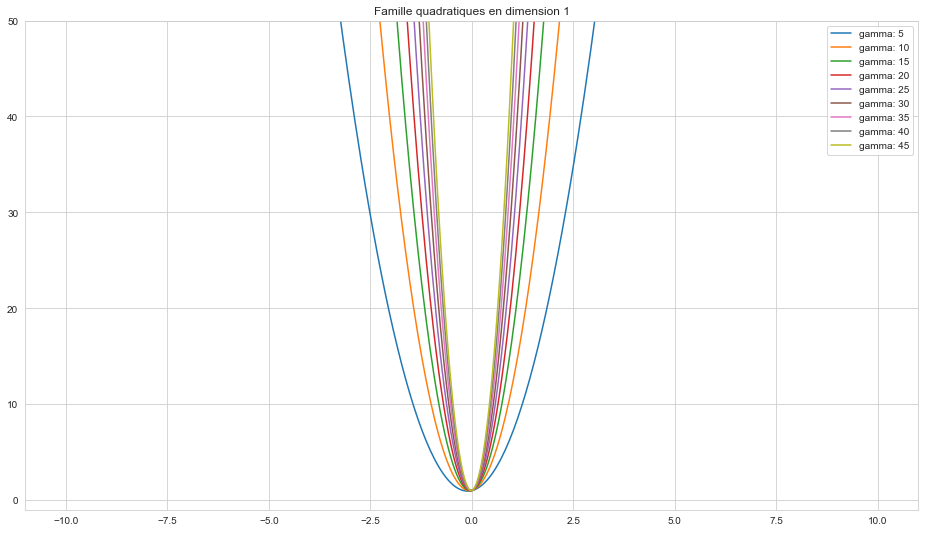

In [6]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 50)
for gamma in range(5, 50, 5):
    ax.plot(x, quad_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille quadratiques en dimension 1")
ax.legend()

In [7]:
cubic_I_d = { 
    "name": "cubic_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False,
    "value" : (lambda x, gamma: x**3 + gamma*x**2 + x + 1),
    "grad"  : (lambda x, gamma: 3*x**2 + 2*gamma*x + 1),
    "hess"  : (lambda x, gamma: 6*x + 2*gamma),
    "HCN"   : (lambda x, gamma: 1 ) 
}

cubic_I = test_family(**cubic_I_d)

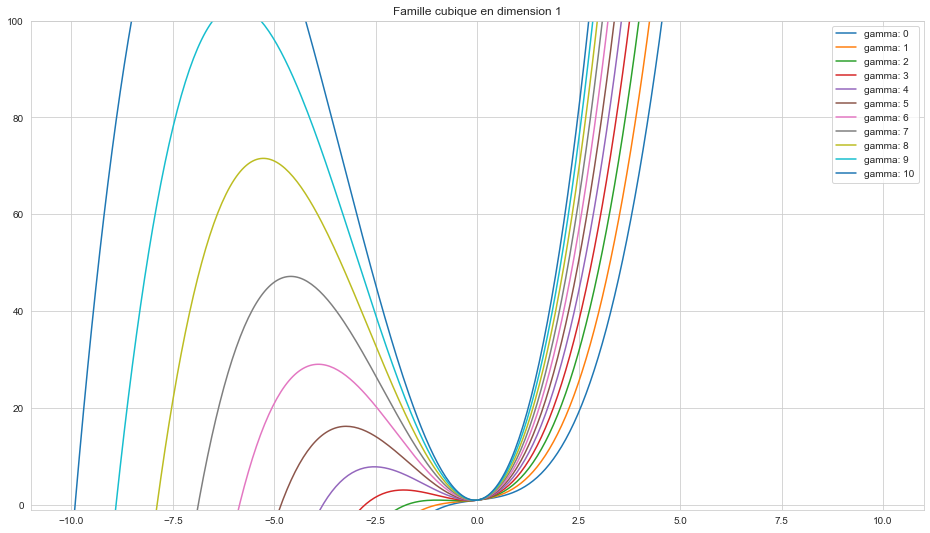

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 100)
for gamma in range(0, 11, 1):
    ax.plot(x, cubic_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille cubique en dimension 1")
ax.legend()

In [9]:
exp_I_d = {
    "name": "exp_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: np.exp(gamma*x) + np.exp(-gamma*x)),
    "grad"  : (lambda x, gamma: gamma*(np.exp(gamma*x) - np.exp(-gamma*x))),
    "hess"  : (lambda x, gamma: (gamma**2)*(np.exp(gamma*x) + np.exp(-gamma*x))),
    "HCN"   : (lambda x, gamma: 1 )    
}

exp_I = test_family(**exp_I_d)

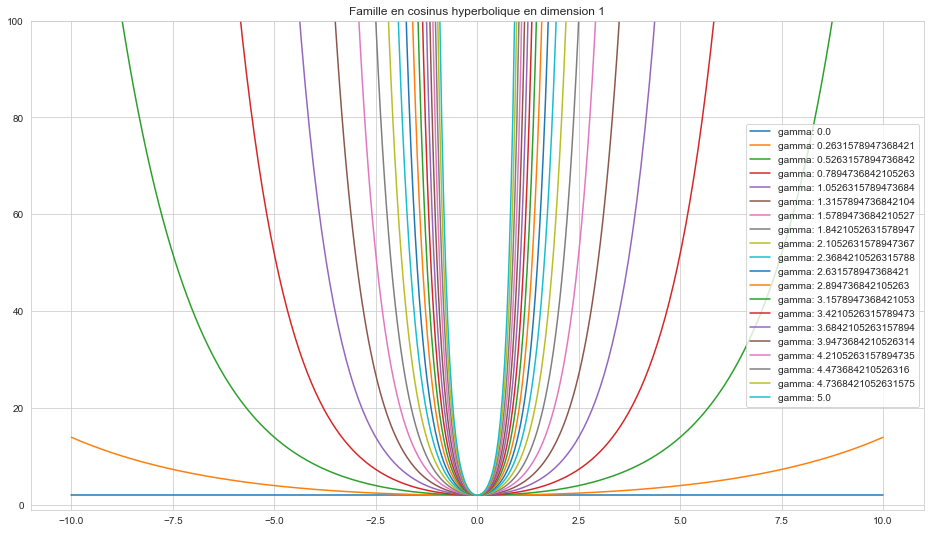

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-1, 100)
params = np.linspace(0, 5, 20)
for gamma in params:
    ax.plot(x, exp_I.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille en cosinus hyperbolique en dimension 1")
ax.legend()

In [11]:
multi_sinks_d = {
    "name": "multi_sinks_1",
    "dim" : 1,
    "nb_params" : 1,
    "convex" : False ,
    "value" : (lambda x, gamma: 20*np.cos(x**2) + (gamma * x**2)),
    "grad"  : (lambda x, gamma: np.sin(x) + 2*gamma*x),
    "hess"  : (lambda x, gamma: np.cos(x) + 2*gamma),
    "HCN"   : (lambda x, gamma: 1 )  
}

multi_sinks = test_family(**multi_sinks_d)

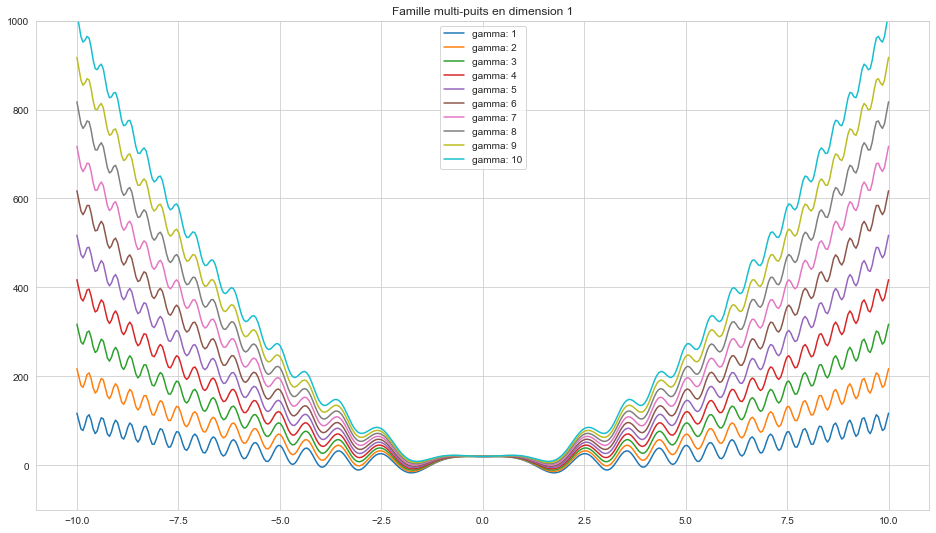

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
x = np.linspace(-10, 10, 400)
ax.set_ylim(-100, 1000)
for gamma in range(1, 11, 1):
    ax.plot(x, multi_sinks.value(x, gamma), label="gamma: {}".format(gamma))
ax.set_title("Famille multi-puits en dimension 1")
ax.legend()

2. Faire de même avec des fonctions sur $\mathbb{R}^2$.

In [13]:
quad_II_d = {
    "name": "quadric_2",
    "dim" : 2,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: x[:, 0]**2 + gamma*x[:, 1]**2),
    "grad"  : (lambda x, gamma: np.array([2*x[:, 0], 2*gamma*x[:, 1]]).reshape(1, -1)),
    "hess"  : (lambda x, gamma: np.diag([2, 2*gamma])),
    "HCN"   : (lambda x, gamma: gamma)
}

quad_II = test_family(**quad_II_d)

In [14]:
quad_II_d["grad"](np.array([[5, 5]]), 1)

array([[10, 10]])

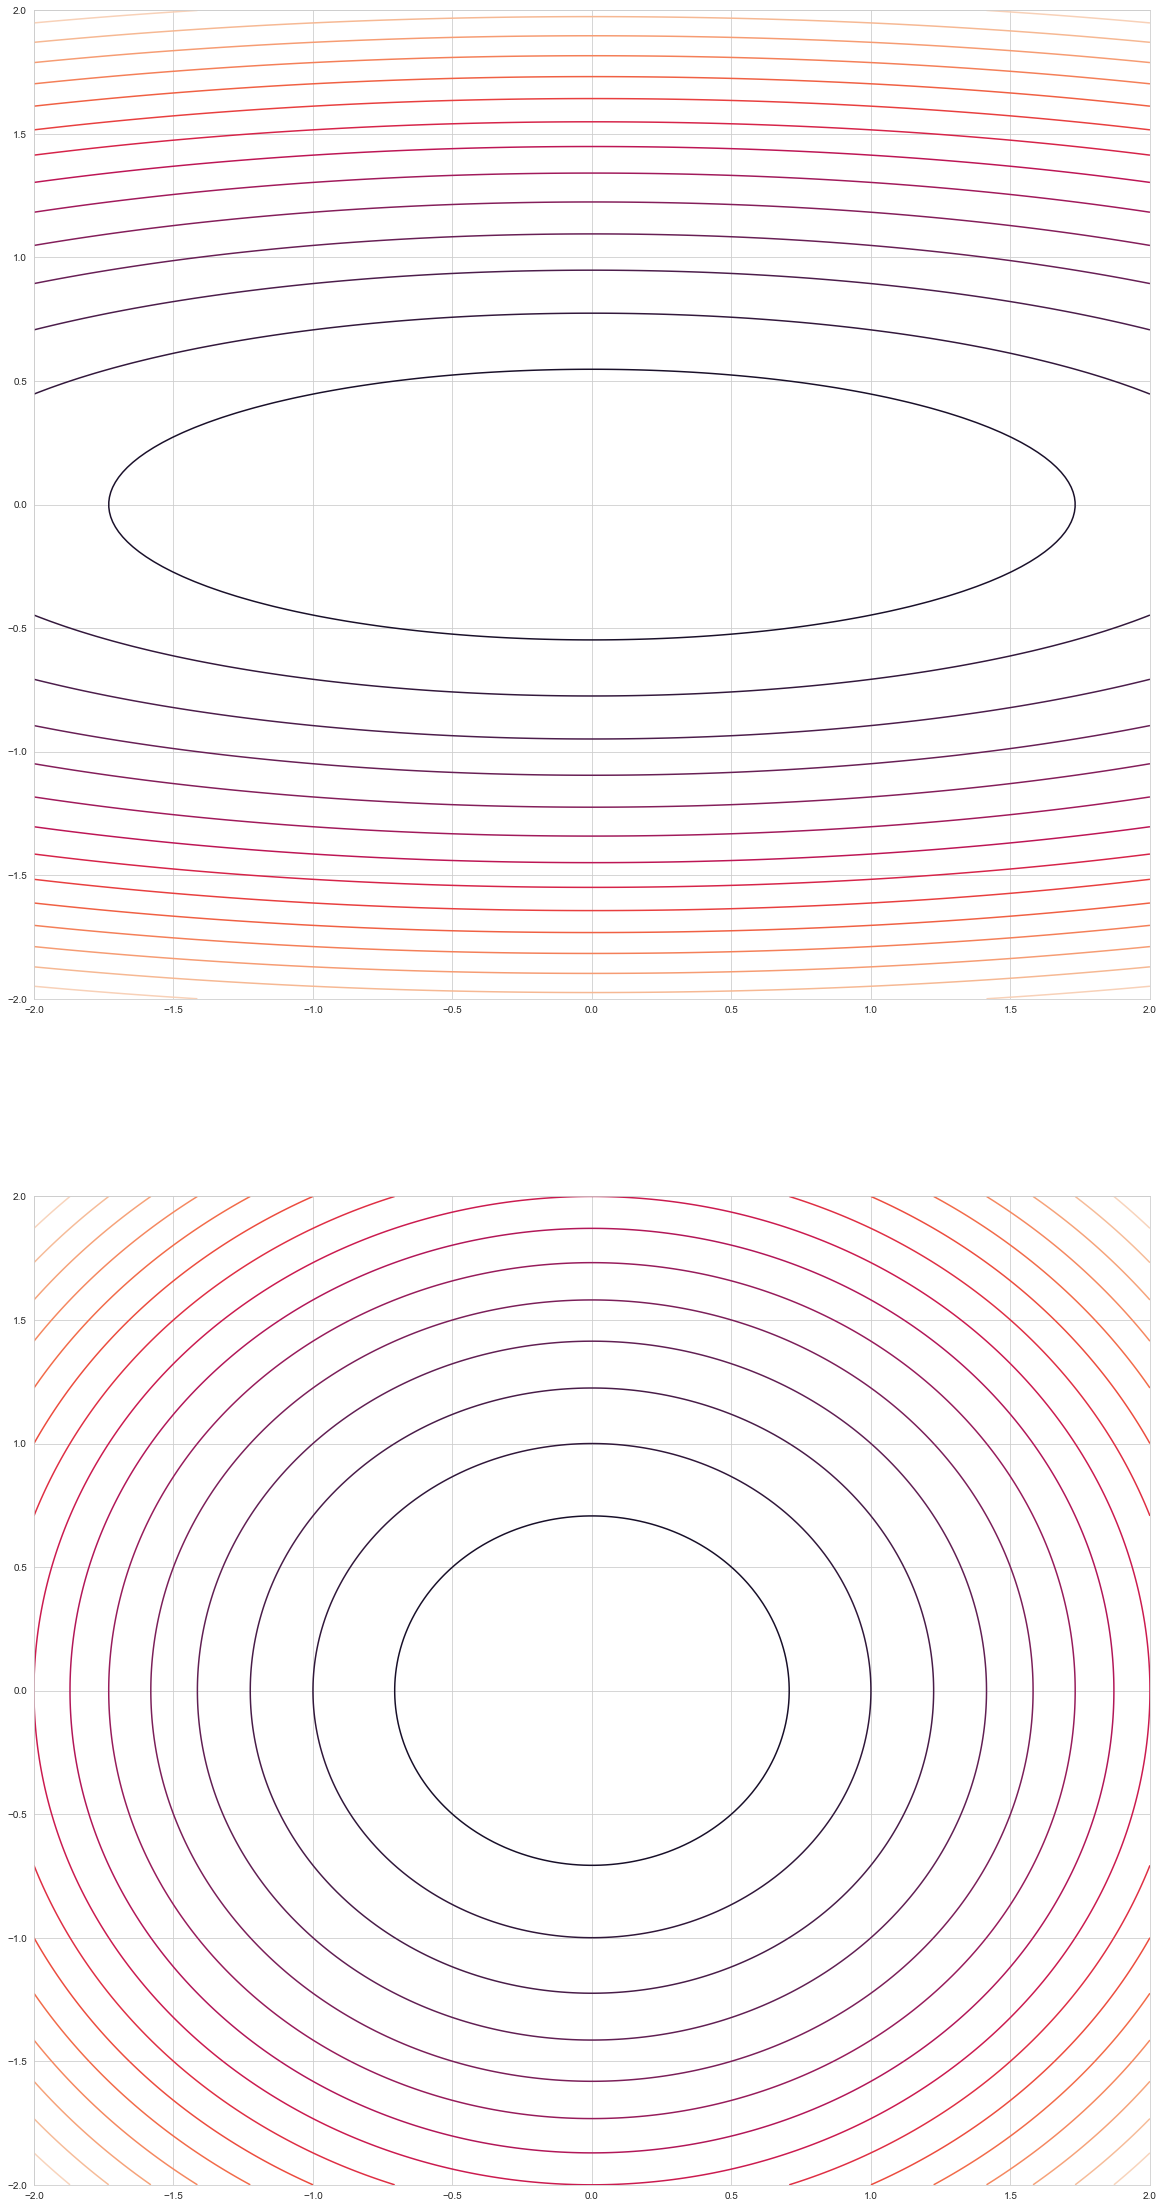

In [15]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(2, 1, figsize=(20, 40))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
for i in [0, 1]:
    ax[i].set_xlim(x_mi, x_ma)
    ax[i].set_ylim(y_mi, y_ma)
ax[0].contour(X, Y, quad_II.value(x_y, 10).reshape(nb_pts, -1), 15)
ax[1].contour(X, Y, quad_II.value(x_y, 1).reshape(nb_pts, -1), 15)

3. Construire des familles de fonctions tests de dimensions de plus en plus grandes en fonction du paramètre. 

In [16]:
quad_III_d = {
    "name": "quadric_3",
    "dim" : 3,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: x[:, 0]**2 + gamma*x[:, 1]**2 + x[:, 2]**2),
    "grad"  : (lambda x, gamma: np.array([2*x[:, 0], 2*gamma*x[:, 1], 2*x[:, 2]]).reshape(1, -1)),
    "hess"  : (lambda x, gamma: np.diag([2, 2*gamma, 2])),
    "HCN"   : (lambda x, gamma: gamma)
}

quad_IV_d = {
    "name": "quadric_4",
    "dim" : 4,
    "nb_params" : 1,
    "convex" : True ,
    "value" : (lambda x, gamma: x[:, 0]**2 + gamma*x[:, 1]**2 + x[:, 2]**2 + + x[:, 3]**2),
    "grad"  : (lambda x, gamma: np.array([2*x[:, 0], 2*gamma*x[:, 1], 2*x[:, 2], 2*x[:, 3]]).reshape(1, -1)),
    "hess"  : (lambda x, gamma: np.diag([2, 2*gamma, 2, 2])),
    "HCN"   : (lambda x, gamma: gamma)
}

quad_III = test_family(**quad_III_d)
quad_IV = test_family(**quad_IV_d)

4. Construire une `test_list` contenant la liste des familles de fonctions tests crées jusque là.

In [17]:
test_list = [quad_I, cubic_I, exp_I, multi_sinks, quad_II, quad_III, quad_IV]

## Différencier une fonction

Pour calculer le gradient d'une fonction on a déjà besoin de savoir calculer la dérivée d'une fonction réelle. On s'intéresse à cette question dans cette section. Le point central est le fait qu'approcher numériquement la dérivée d'une fonction réelle est *prone* aux erreurs numériques ; on est souvent dans une meilleure posture lorsque l'on a une expression explicite pour le gradient d'une fonction.

### L'approche naïve

On rappelle que pour une fonction numérique le nombre dérivée d'une fonction $f : \mathbb{R} \to \mathbb{R}$ en un point $x \in \mathbb{R}$ est donnée par la limite :

$$ f'(x) = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h} $$

quand celle-ci existe. D'un point de vue numérique une assez petite valeur $h$ donne un quotient suffisamment proche du nombre dérivée que l'on cherche. Ainsi pour $h$ assez petit on approche $f'(x)$ par 

$$ f'(x) \simeq \frac{f(x + h) - f(x)}{h} .$$

L'erreur à l'approximation est en $o(1)$ en $0$. 

1. Coder une fonction `partial_` qui calcule la dérivée partielle d'une fonction à plusieurs variables en utilisant la démarche précédente.

In [18]:
def partial_(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x)) / dx

2. Tester votre fonction sur un exmple dont vous connaissez la dérivée partielle et comparer vos résutlats.

In [19]:
partial_(lambda x: np.exp(x), np.array([100]))

array([[2.68811848e+43]])

In [20]:
np.exp(np.array([100]))

array([2.68811714e+43])

**La différence est *petite* ou *grande*?**

La diff entre les deux resultats est petite mais visible aux 6emes chiffres apres la virgule

### Une démarche un peu moins naïve

On peut en réalité faire un peu mieux ; le nombre dérivée est également la limite 

$$ f'(x) = \lim_{h \to 0} \frac{f(x+h)-f(x-h)}{2h} $$.

On approche donc $f'(x)$ par 

$$f'(x) \simeq \frac{f(x+h)-f(x-h)}{2h}$$.

La différence avec la première approximation résulte de l'écriture du DL du numérateur de cette seconde écriture (en supposant $f$ deux fois différentiable:

$$f(x + h) - f(x - h) = (f(x) + hf'(x) + \frac{h^2}{2}f''(x) + o(h^2)) - (f(x) - hf'(x) + \frac{h^2}{2} f''(x) + o(h^2))$$

Et donc:

$$f(x + h) - f(x - h) = 2hf'(x) + o(h^2)$$.

On trouve que l'erreur d'approximation dans le second cas est désormais $o(h)$ ; ce qui est supposé être une meilleure approximation que dans le premier cas.

**Remarque : si l'on souhaite faire un calcul précis de l'erreur dans l'approximation de la dérivée de $f$ en un point on s'y prendrait pas tout à fait comme cela, nous ne donnons ici qu'une vague idée de la différence entre les deux démarches précédentes.**

1. Utiliser la démarche précédente pour approcher la dérivée partielle d'une fonction en un point. Cette fonction sera notée `partial`.

In [21]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

2. Comparer `partial` à `partial_` et à l'expression exacte de la dérivée partielle d'une fonction de votre choix. 

In [22]:
partial(lambda x: np.exp(x), np.array([100]))

array([[2.68811713e+43]])

In [23]:
np.exp(np.array([100]))

array([2.68811714e+43])

Il est possible de raffiner d'avantage l'estimation de la dérivée d'une fonction en un point. On se contente de ces deux premières approches simples. Pour plus de détail vous pouvez vous référer au cours d'Analyse numérique de J-P. Demailly.

4. Effectuer des tests plus larges sur les divergences des différents schémas d'approximation précédents.

# TODO

In [24]:
test_list_2 = [quad_I, cubic_I, exp_I, multi_sinks]
for func in test_list_2:
    print(func.name)
    print("true result: ", func.grad(100, 1))
    print("result of partial: ", partial(lambda x: func.value(x, 1), np.array([100])))
    print("result of partial_: ", partial_(lambda x: func.value(x, 1), np.array([100])))
    print()

quadratic_1
true result:  201
result of partial:  [[200.99999983]]
result of partial_:  [[201.00000074]]

cubic_1
true result:  30201
result of partial:  [[30200.99998685]]
result of partial_:  [[30201.00027788]]

exp_1
true result:  2.6881171418161356e+43
result of partial:  [[2.68811713e+43]]
result of partial_:  [[2.68811848e+43]]

multi_sinks_1
true result:  199.49363435889023
result of partial:  [[1422.45754341]]
result of partial_:  [[1422.8384116]]



### Le calcul du gradient

On sait déjà par la démarche précédente que l'approximation numérique de la dérivée partielle d'une fonction en un point sera difficilement meilleure qu'une expression exacte. Parfois on n'est pas en mesure de trouver facilement et à la main la dérivée partielle d'une fonction ; on se garde donc la possibilité de calculer numériquement le gradient d'une fonction.

- Écrire une fonction `gradient` qui renvoie le gradient d'une fonction en un point.

In [25]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([partial(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

In [26]:
gradient(lambda x: x[0, 0]**5 + x[0, 1]*2, np.array([1, 10]))

array([[5., 2.]])

## La classe `GD`

La classe correspond à l'interface par laquelle on va implémenter et comparer les différentes variantes des descentes de gradients. L'objectif de cette section est de remplir les différents composants de calcul du principe qu'on a vu en cours. 

In [27]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x = rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

### GD dans le cas d'un pas constant

Pour être en mesure de faire nos premiers tests d'utilisation de `GD` il nous faut encore se préoccuper des quelques hyperparamètres à fixer. On commence en un premier temps par tester la descente de gradient classique à pas constants.
 

1. Mettre les valeurs par défaut pour les attributs de `GD` de facon à obtenir une descente de gradients classique à pas constant et une condition d'arrêt donnée par le fait que le gradient en un point tombe en-deça d'un certain seuil de tolérance.

*Fait pour vous dans la GD, plus haut.*

2. Tester cette descente de gradient classique sur les différentes fonctions tests. Répertorier dans un tableau le point initial de chaque descente, le nombre d'itérations, le pas choisi et la valeur objectif obtenue.

Cherchons d'abord à manipuler la classe qu'on vient de construire

In [28]:
GD_default = GD()

In [29]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : quad_I.value (x, 2)), 
                                             (lambda x, f, tol : quad_I.grad (x, 2)), True)

 Iteration nu. = 430
 approx. = [-0.24999976]
 ob value = [[0.875]]
 and decay = 9.759196527570069e-07.


On peut visualiser dans lors de l'optimisation de problèmes de petites dimensions les itérés de la descente. `matplotlib` est là pour  vous aider dans votre démarche.

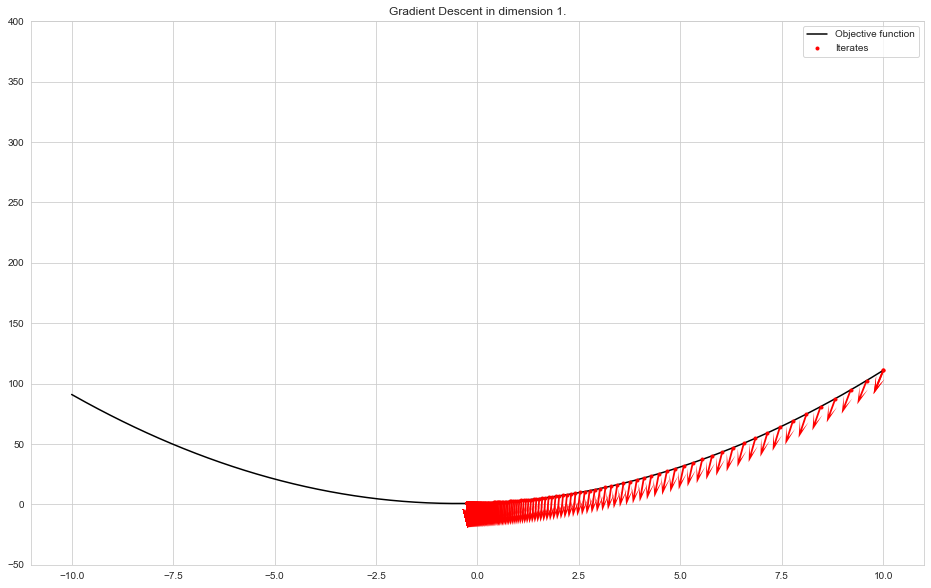

In [30]:
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: quad_I.value (x, 1)
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.002, headwidth=5, headlength=10)
ax.set_title("Gradient Descent in dimension 1.")
ax.legend()

On se contente ici de travailler avec les fonctions tests de dimension $1$. **À vous de généraliser.**

In [31]:
test_list_d1 = [test_family for test_family in test_list if test_family.dim == 1]

In [32]:
init_pt = np.array([1])

In [33]:
gamma = 3

In [34]:
cst_rate = 0.02

In [35]:
import pandas as pd

In [36]:
#TODO
GD_test_summary = pd.DataFrame(columns=["init_pt", "rate", "optimal_pt", "nb_iter"])
GD_list = {}
for t_function in test_list:
    init_pt = np.array([[1] * t_function.dim])
    idt = 0
    GD_list[t_function.name] = GD(rate = lambda x, f, dir_x, grad, nb_iter, eta : cst_rate)
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                    (lambda x: t_function.value (x, gamma)), 
                                                    (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, idt)
    GD_test_summary.loc[naming_format] = pd.Series({"init_pt": init_pt, 
                                                     "rate": GD_list[t_function.name].rate (*[None]*6), 
                                                     "optimal_pt": opt_pt, 
                                                     "nb_iter": n_iter})
    idt += 1
GD_test_summary

,init_pt,rate,optimal_pt,nb_iter
quadratic_1_0,[[1]],0.02,[[-0.16666651433221408]],124
cubic_1_0,[[1]],0.02,[[-0.1835032320903282]],146
exp_1_0,[[1]],0.02,[[-4.9047386253786754e-08]],35
multi_sinks_1_0,[[1]],0.02,[[1.344899772081389e-07]],105
quadric_2_0,"[[1, 1]]",0.02,"[[4.881563714065751e-07, 1.7211997941093527e-20]]",356
quadric_3_0,"[[1, 1, 1]]",0.02,"[[3.5215091924726516e-07, 6.190028700498923e-2...",364
quadric_4_0,"[[1, 1, 1, 1]]",0.02,"[[2.8713424498896236e-07, 3.2666757111613094e-...",369


3. Étudier pour un sous-ensemble de votre choix la relation entre le pas de la descente et le nombre d'itérations. Prendre soins de bien vérifier que vous avez convergence.

In [37]:
init_pt = np.array([10])

In [38]:
gammas = np.linspace(1, 10, 5)
gammas

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [39]:
cst_rates = np.linspace(0.01, 0.5, 200)

In [40]:
GD_rate_iter = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter"])
GD_list_ri = {}
for t_function in test_list_d1:
    for gamma in gammas:
        idt = 0
        for cst_rate in cst_rates:
            GD_list_ri[t_function.name] = GD(rate = lambda x, f, dir_x, grad, nb_iter, eta : cst_rate)
            opt_pt, _, _, n_iter = GD_list_ri[t_function.name](init_pt, 
                                                               (lambda x: t_function.value (x, gamma)), 
                                                               (lambda x, f, tol : t_function.grad(x, gamma)))
            naming_format = "{}_{}_{}".format(t_function.name, idt, gamma)
            GD_rate_iter.loc[naming_format] = pd.Series({"gamma": gamma, 
                                                         "rate": GD_list_ri[t_function.name].rate (*[None]*6), 
                                                         "optimal_pt": opt_pt,
                                                         "optimal_val": t_function.value(opt_pt, gamma),
                                                         "nb_iter": n_iter})
            idt += 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Decay didn't get under tolerance rate.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in multiply
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in add
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/anaconda3/lib/python3.7/site-packages/ipykerne

In [41]:
list_of_test_types = ["quadratic", "cubic", "exp", "multisinks"]

In [42]:
 GD_rate_iter[GD_rate_iter.index.str.contains("quadratic", regex=False)]

,gamma,rate,optimal_pt,optimal_val,nb_iter
quadratic_1_0_1.0,1.0,0.010000,[[-0.49999950459258535]],[[0.7500000000002454]],835
quadratic_1_1_1.0,1.0,0.012462,[[-0.49999950031085555]],[[0.7500000000002497]],668
quadratic_1_2_1.0,1.0,0.014925,[[-0.49999950950128774]],[[0.7500000000002406]],557
quadratic_1_3_1.0,1.0,0.017387,[[-0.4999995110595206]],[[0.750000000000239]],477
quadratic_1_4_1.0,1.0,0.019849,[[-0.499999515645947]],[[0.7500000000002346]],417
...,...,...,...,...,...
quadratic_1_195_10.0,10.0,0.490151,[[nan]],[[nan]],326
quadratic_1_196_10.0,10.0,0.492613,[[nan]],[[nan]],326
quadratic_1_197_10.0,10.0,0.495075,[[nan]],[[nan]],325
quadratic_1_198_10.0,10.0,0.497538,[[nan]],[[nan]],324


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


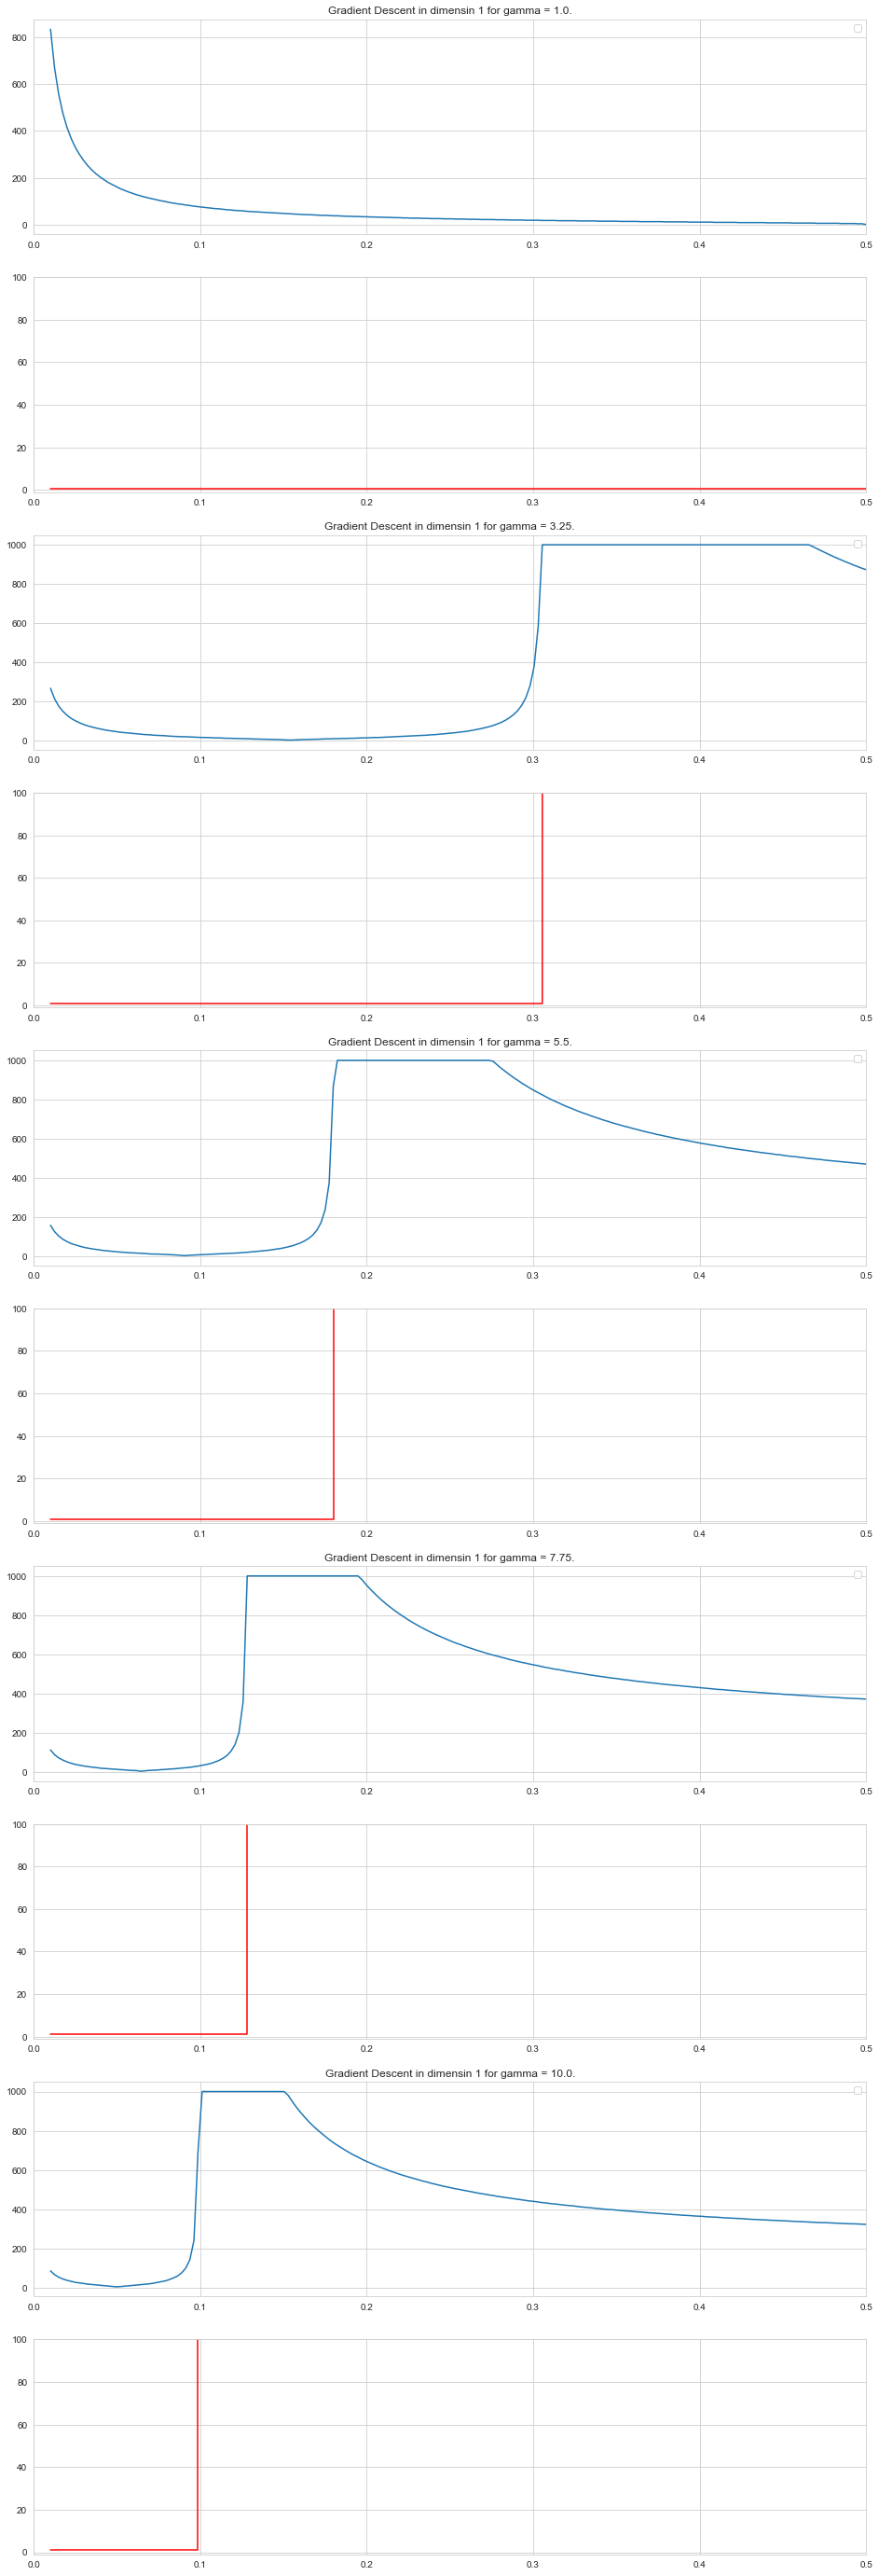

In [43]:
nb_figures = 2*len(gammas)
fig, ax = plt.subplots(nb_figures, 1, figsize=(16, 5*nb_figures))
selection = GD_rate_iter.index.str.contains("quadratic", regex=False)
i = 0
for gamma in gammas:
    df_selected = GD_rate_iter[(selection) & (GD_rate_iter["gamma"] == gamma)]
    ax[i].plot(df_selected["rate"], df_selected["nb_iter"])
    ax[i].set_xlim(0, 0.5)
    ax[i+1].plot(df_selected["rate"], df_selected["optimal_val"], "r")
    ax[i+1].set_ylim(-1, 100)
    ax[i+1].set_xlim(0, 0.5)
    ax[i].set_title("Gradient Descent in dimensin 1 for gamma = {}.".format(gamma))
    ax[i].legend()
    i += 2

Pour la fonction quadratique de dimension 1, nous pouvons observer que lorsque notre pas est trop grand, cela ne permet plus de trouver une valeur optimale. Par exemple, la pente de la courbe en fonction du gamma est plus ou moins importante, ce qui entrainera, si notre pas est trop grand un "saut" sur l'autre pente ce qui ne permettra jamais de trouver le point optimal.

4. Étudier la relation entre la vitesse de convergence et le point initial de votre descente dans le cas des fonctions numériques.

In [44]:
# TODO
inits_pt = np.arange(-100,100,10)
gammas = np.linspace(1, 10, 5)
GD_start_iter = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "optimal_val", "nb_iter"])
GD_list_ri = {}
for t_function in test_list_d1:
    for gamma in gammas:
        for init_pt in inits_pt:
            GD_list_ri[t_function.name] = GD(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
            opt_pt, _, _, n_iter = GD_list_ri[t_function.name](init_pt, 
                                                               (lambda x: t_function.value (x, gamma)), 
                                                               (lambda x, f, tol : t_function.grad(x, gamma)))
            naming_format = "{}_{}_{}".format(t_function.name, idt, gamma)
            GD_start_iter.loc[naming_format] = pd.Series({"gamma": gamma, 
                                                         "init_pt": init_pt, 
                                                         "optimal_pt": opt_pt,
                                                         "optimal_val": t_function.value(opt_pt, gamma),
                                                         "nb_iter": n_iter})
            idt += 1
GD_start_iter

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in add


,gamma,init_pt,optimal_pt,optimal_val,nb_iter
quadratic_1_200_1.0,1.0,-100,[[-0.5000004985292974]],[[0.7500000000002485]],946
quadratic_1_201_1.0,1.0,-90,[[-0.5000004960897592]],[[0.750000000000246]],941
quadratic_1_202_1.0,1.0,-80,[[-0.5000004974482429]],[[0.7500000000002475]],935
quadratic_1_203_1.0,1.0,-70,[[-0.5000004909181883]],[[0.7500000000002409]],929
quadratic_1_204_1.0,1.0,-60,[[-0.5000004940065174]],[[0.750000000000244]],921
...,...,...,...,...,...
multi_sinks_1_595_10.0,10.0,50,[[4.7353903550428116e-08]],[[20.00000000000002]],89
multi_sinks_1_596_10.0,10.0,60,[[4.540841557956357e-08]],[[20.00000000000002]],90
multi_sinks_1_597_10.0,10.0,70,[[4.2241030376779985e-08]],[[20.000000000000018]],91
multi_sinks_1_598_10.0,10.0,80,[[3.8349718169090407e-08]],[[20.000000000000014]],92


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


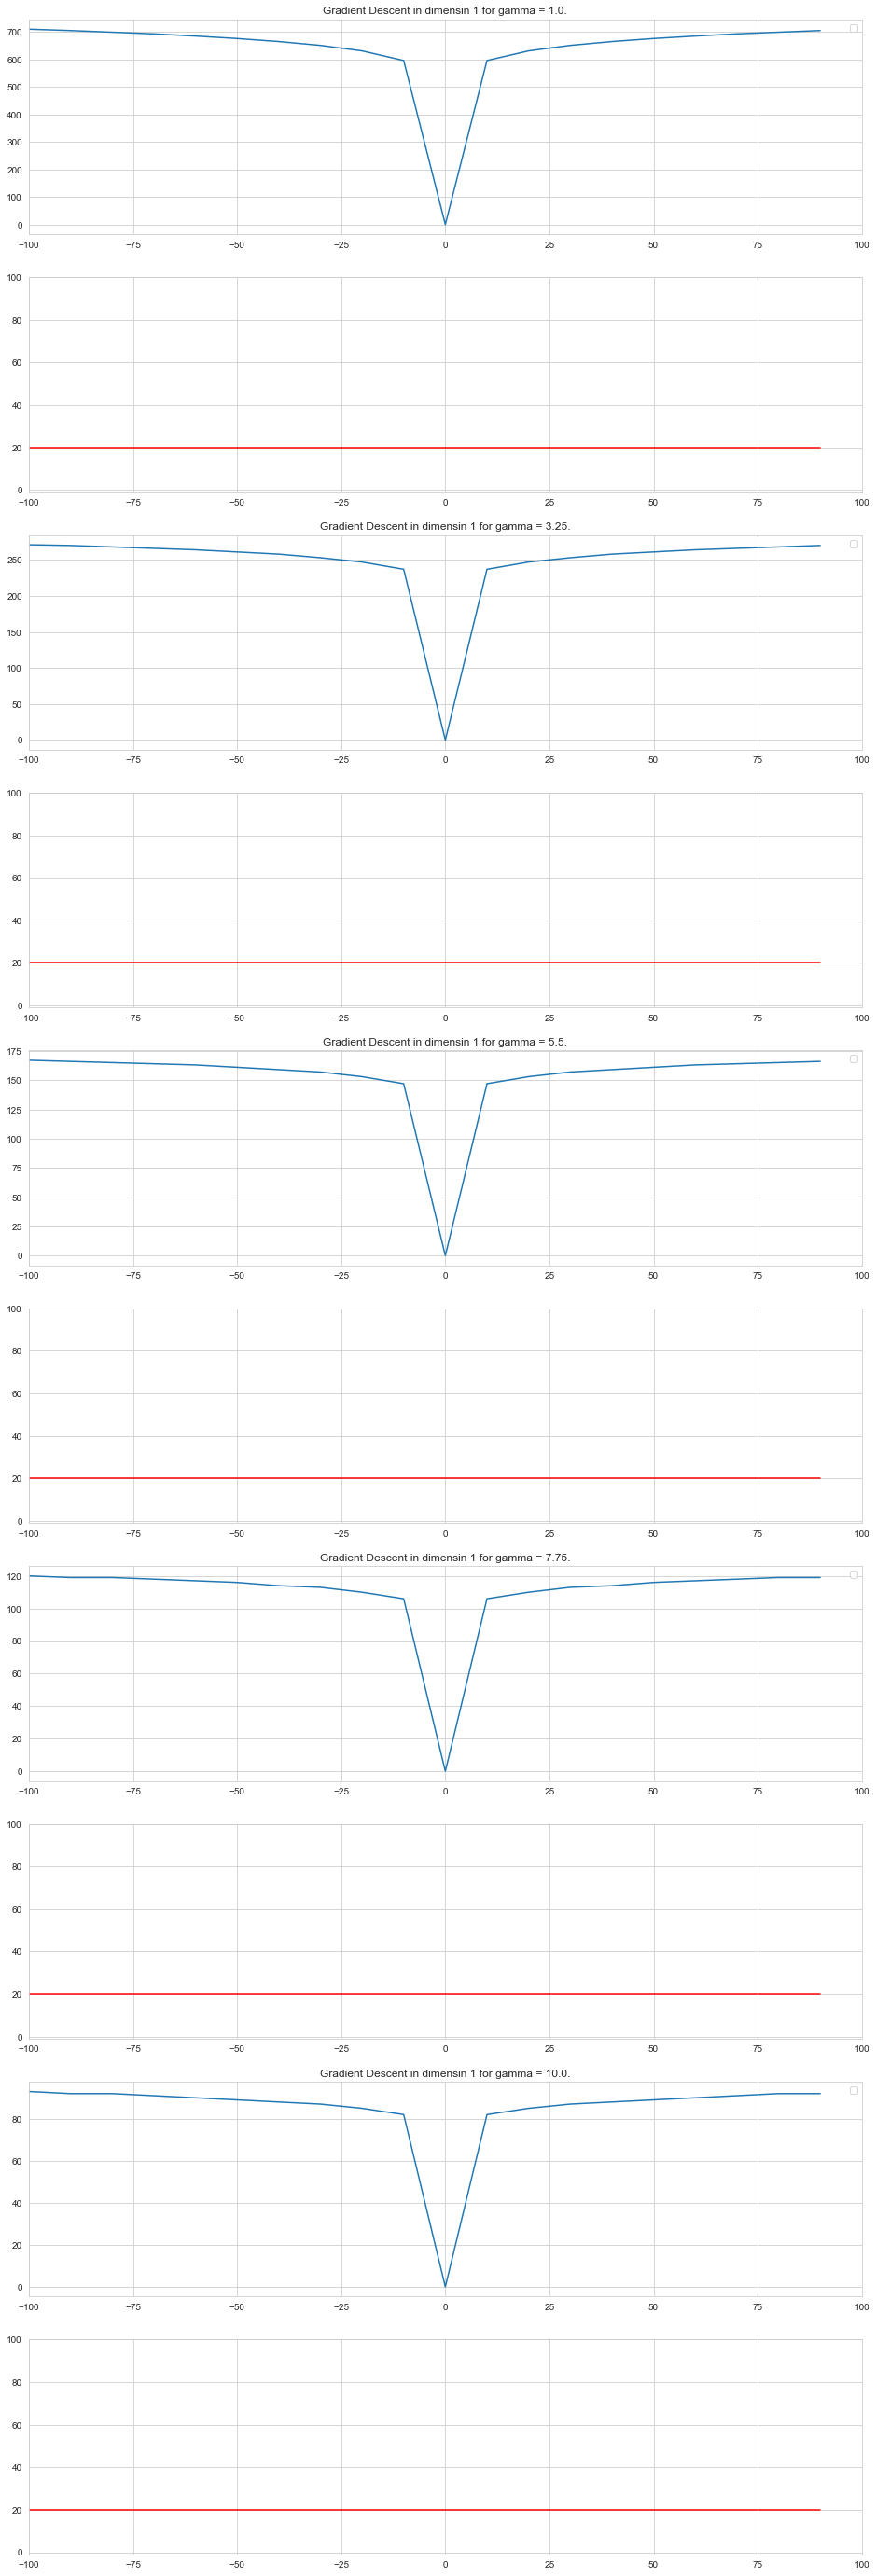

In [45]:
nb_figures = len(gammas)*2
fig, ax = plt.subplots(nb_figures, 1, figsize=(16, 5*nb_figures))
selection = GD_start_iter.index.str.contains("multi_sinks", regex=False)
i = 0
for gamma in gammas:
    df_selected = GD_start_iter[(selection) & (GD_start_iter["gamma"] == gamma)]
    ax[i].plot(df_selected["init_pt"], df_selected["nb_iter"])
    ax[i].set_xlim(-100, 100)
    ax[i+1].plot(df_selected["init_pt"], df_selected["optimal_val"], "r")
    ax[i+1].set_ylim(-1, 100)
    ax[i+1].set_xlim(-100, 100)
    ax[i].set_title("Gradient Descent in dimensin 1 for gamma = {}.".format(gamma))
    ax[i].legend()
    i += 2

On peut observer que pour les fonctions cubiques, la pente défini si on va tomber dans le moins infini ou dans le  min local.
De plus on peut noter que pour les fonctions quadratiques, la convergence va dépendre du point initial de la descente, car plus il est proche, plus  il converge vite et de gamma car il défini la pente de la fonction. Il en est de même pour les fonctions exponentielles.

### GD dans le cas de *backtracking*

Vous devriez avoir constatés que le choix du pas de descente dans le cas constant est crucial pour garantir la convergence de l'algorithme de descente. Dans cette section on s'intéresse à un calcul adaptatif du pas de descente qui permet de mieux garantir la convergence de notre algo. Le désavatage est le temps que prend désormais chaque itération pour s'exécuter.

1. Écrire une fonction `backtracking` qui permet de calculer le pas par *backtracking* à une itération donnée. Pour rappel le *backtracking* a deux hyper-paramètre $\alpha$ et $\beta$ respectivement mis par défaut à $0.01$ et $0.08$.

In [46]:
class backtracking():
    
    def __init__(self, alpha=0.01, beta=0.8, max_iter=100):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        
    def __call__(self, x, f, dir_x, grad, n_iter, eta, tol=1e-6):
        n_while = 0
        t = 1
        x = x.reshape(1, -1)
        grad_f = grad(x, f, tol)
        while f(x + t * dir_x) > f(x) + self.alpha * t * grad_f.dot(dir_x.T) and n_while < self.max_iter:
            t = self.beta * t
            n_while += 1
        return t

2. Comparer la GD par backtracking aux tests effectués jusqu'à présent dans le cas d'une GD à pas constant (à vous de réfléchir à ce que vous voulez comparer).

In [47]:
bt_rate = backtracking()

In [48]:
gammas

array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

In [49]:
GD_ri_bt = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter"])
GD_list_bt = {}
for t_function in test_list_d1:
    for gamma in gammas:
        GD_list_bt[t_function.name] = GD(rate = bt_rate)
        opt_pt, _, _, n_iter = GD_list_bt[t_function.name](init_pt, 
                                                           (lambda x: t_function.value (x, gamma)), 
                                                           (lambda x, f, tol : t_function.grad(x, gamma)))
        naming_format = "{}_{}".format(t_function.name, gamma)
        GD_ri_bt.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                                  "rate" : "backtracking",
                                                  "optimal_pt": opt_pt,
                                                  "optimal_val": t_function.value(opt_pt, gamma),
                                                  "nb_iter": n_iter })
GD_ri_bt

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in power
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in square
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipyk

,gamma,rate,optimal_pt,optimal_val,nb_iter
quadratic_1_1.0,1.00,backtracking,[[-0.49999966395604006]],[[0.7500000000001129]],38
quadratic_1_3.25,3.25,backtracking,[[-0.15384602445384296]],[[0.9230769230769775]],58
quadratic_1_5.5,5.50,backtracking,[[-0.0909090084247701]],[[0.954545454545492]],124
quadratic_1_7.75,7.75,backtracking,[[-0.06451607685407254]],[[0.9677419354838921]],52
quadratic_1_10.0,10.00,backtracking,[[-0.05000003999984123]],[[0.975000000000016]],65
cubic_1_1.0,1.00,backtracking,[[-inf]],[[nan]],7
cubic_1_3.25,3.25,backtracking,[[-inf]],[[nan]],7
cubic_1_5.5,5.50,backtracking,[[-inf]],[[nan]],7
cubic_1_7.75,7.75,backtracking,[[-inf]],[[nan]],7
cubic_1_10.0,10.00,backtracking,[[-inf]],[[nan]],7


In [50]:
GD_ri = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter"])
GD_list = {}
for t_function in test_list_d1:
    for gamma in gammas:
        GD_list[t_function.name] = GD()
        opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                           (lambda x: t_function.value (x, gamma)), 
                                                           (lambda x, f, tol : t_function.grad(x, gamma)))
        naming_format = "{}_{}".format(t_function.name, gamma)
        GD_ri.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                                  "rate" : GD_list[t_function.name].rate (*[None]*6),
                                                  "optimal_pt": opt_pt,
                                                  "optimal_val": t_function.value(opt_pt, gamma),
                                                  "nb_iter": n_iter })
GD_ri

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in add


,gamma,rate,optimal_pt,optimal_val,nb_iter
quadratic_1_1.0,1.00,0.01,[[-0.4999995083999917]],[[0.7500000000002417]],942
quadratic_1_3.25,3.25,0.01,[[-0.15384600618062266]],[[0.923076923076994]],301
quadratic_1_5.5,5.50,0.01,[[-0.09090900258032714]],[[0.9545454545454974]],178
quadratic_1_7.75,7.75,0.01,[[-0.06451607426776804]],[[0.9677419354838942]],126
quadratic_1_10.0,10.00,0.01,[[-0.04999995521604256]],[[0.9750000000000201]],96
cubic_1_1.0,1.00,0.01,[[-inf]],[[nan]],10
cubic_1_3.25,3.25,0.01,[[-inf]],[[nan]],10
cubic_1_5.5,5.50,0.01,[[-inf]],[[nan]],10
cubic_1_7.75,7.75,0.01,[[-inf]],[[nan]],10
cubic_1_10.0,10.00,0.01,[[-inf]],[[nan]],10


On remarque qu'avec le backtracking on a une convergence plus rapide et des resultats plus pertinents que sans le backtracking. Cela se remarque bien avec la fonction *multi_sinks* qui a 2 optimum locaux de meme valeurs en ~1.7 et 1.7.

La fonction *cubic* qui n'as pas d'optimum locaux est bien representee au contraire de *exp* 

### Changer de direction de descente

On a explicité en cours trois types de descentes : 

 - La déscente standard : la direction de descente est celle du gradient, ce qu'on vient de regarder.
 - La déscente de plus forte pente dans le cas de la norme $\ell_1$ : la direction de descente suit le vecteur de la base canonique de plus grande dérivée partielle en valeur absolue.
 - L'algorithme de Newton où il s'agit de calculer l'inverse des hessiennes au point courant. 
 
*L'algorithme de Newton sera abordé dans une section à part.* On va donc se concentrer pour commencer sur le cas de descente en norme $\ell_1$. 
 

1. Écrire une fonction `dsgd` qui calcule la direction de descente de plus forte pente dans le cas de la norme $\ell_1$. 

In [51]:
def dsgd(x, f, grad, tol):
    x = x.reshape(1, -1)
    dim = x.shape[1]
    sdescent = np.array([0]*dim, dtype=float).reshape(1, -1)
    grad_f = grad(x, f, tol)
    abs_grad = np.abs(grad_f)
    imax_diff = np.argmax(abs_grad) 
    sdescent[0, imax_diff] = grad_f[0, imax_diff]
    return (- sdescent)      

2. Comparer la descente de gradient $\ell_1$ à la descente classique.

 Iteration nu. = 355
 approx. = [1.98860989e-07]
 ob value = [[20.]]
 and decay = 9.943049446657974e-07.
 Iteration nu. = 355
 approx. = [1.98860989e-07]
 ob value = [[20.]]
 and decay = 9.943049446657974e-07.


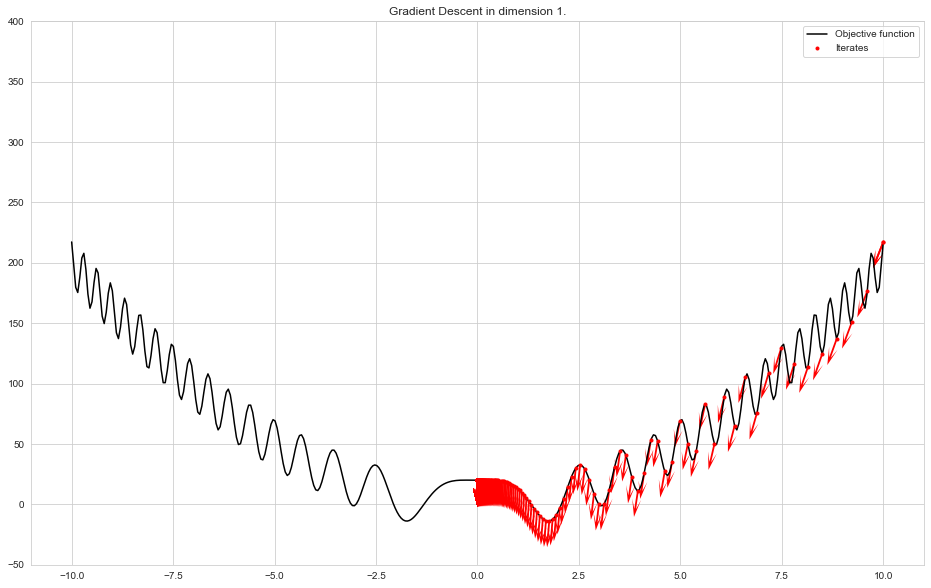

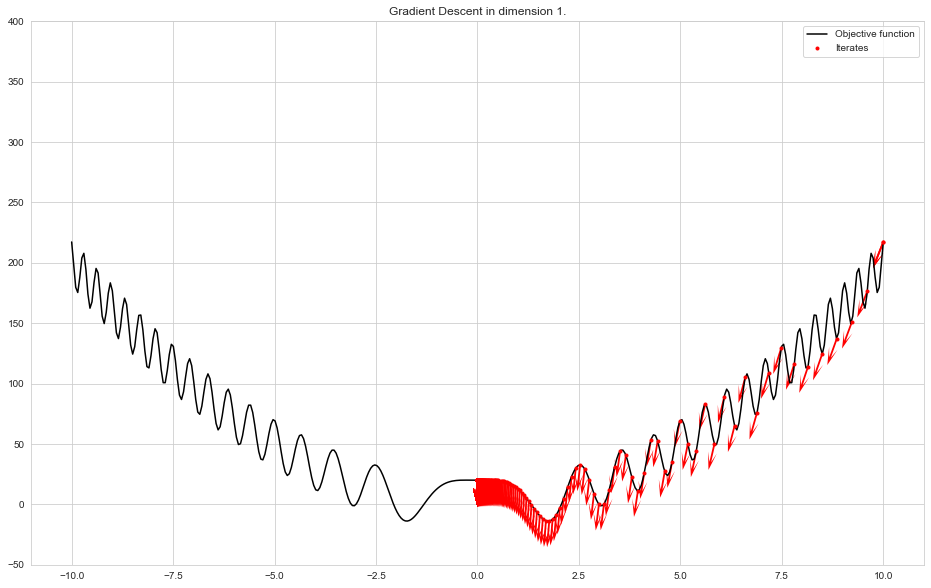

In [52]:
GD_default = GD()
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : multi_sinks.value (x, 2)), 
                                             (lambda x, f, tol : multi_sinks.grad (x, 2)), True)
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: multi_sinks.value (x, 2)
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.002, headwidth=5, headlength=10)
ax.set_title("Gradient Descent in dimension 1.")
ax.legend()

GD_dsgd = GD(ddir= dsgd)
op_pt, iters, iters_dir, n_iter = GD_dsgd(np.array([10]), (lambda x : multi_sinks.value (x, 2)), 
                                             (lambda x, f, tol : multi_sinks.grad (x, 2)), True)

fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: multi_sinks.value (x, 2)
x = np.linspace(-10, 10, 400)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.002, headwidth=5, headlength=10)
ax.set_title("Gradient Descent in dimension 1.")
ax.legend()

Effectuer une telle comparaison en dimension $1$ n'a pas de sens (pourquoi?). On fait donc une partie de l'étude précédente en dimension $2$ pour avoir un référentiel de comparaison.

### Reponse

Ca n'a aucun interety de faire cela sur des fonctions de dimensions $1$ car le principe est de suivre le "vecteur de la plus grande dérivée partielle en valeur absolue".

In [53]:
test_list_d2 = [test_family for test_family in test_list if test_family.dim == 2]

In [54]:
init_pt_d2 = np.array([[2, 2]])

In [55]:
gammas = np.linspace(1, 10, 10)

In [56]:
GD_ri_2 = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter", "iters", "iters_dir"])
GD_list_2 = {}
for t_function in test_list_d2:
    for gamma in gammas:
        GD_list_2[t_function.name] = GD(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.1)
        opt_pt, iters, iters_dir, n_iter = GD_list_2[t_function.name](init_pt_d2, 
                                                     (lambda x: t_function.value (x, gamma)), 
                                                     (lambda x, f, tol : t_function.grad(x, gamma)))
        naming_format = "{}_{}".format(t_function.name, gamma)
        GD_ri_2.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                                 "rate" : 0.01,
                                                 "optimal_pt": opt_pt,
                                                 "optimal_val": t_function.value(opt_pt, gamma),
                                                 "nb_iter": n_iter,
                                                 "iters": iters,
                                                 "iters_dir": iters_dir})
GD_ri_2.loc[:, "gamma": "nb_iter"]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Decay didn't get under tolerance rate.


,gamma,rate,optimal_pt,optimal_val,nb_iter
quadric_2_1.0,1.0,0.01,"[[3.2910091146424137e-07, 3.2910091146424137e-...",[2.1661481985318886e-13],70
quadric_2_2.0,2.0,0.01,"[[4.113761393303017e-07, 9.85068138182558e-16]]",[1.692303280103038e-13],69
quadric_2_3.0,3.0,0.01,"[[4.113761393303017e-07, 6.968982874540769e-28]]",[1.692303280103038e-13],69
quadric_2_4.0,4.0,0.01,"[[4.113761393303017e-07, 1.1805916207173949e-48]]",[1.692303280103038e-13],69
quadric_2_5.0,5.0,0.01,"[[4.113761393303017e-07, 0.0]]",[1.692303280103038e-13],69
quadric_2_6.0,6.0,0.01,"[[4.113761393303017e-07, -1.180591620717441e-48]]",[1.692303280103038e-13],69
quadric_2_7.0,7.0,0.01,"[[4.113761393303017e-07, -6.968982874540931e-28]]",[1.692303280103038e-13],69
quadric_2_8.0,8.0,0.01,"[[4.113761393303017e-07, -9.850681381825706e-16]]",[1.692303280103038e-13],69
quadric_2_9.0,9.0,0.01,"[[5.521397077432454e-08, 5.5213970774325126e-08]]",[3.0485825686680224e-14],78
quadric_2_10.0,10.0,0.01,"[[2.4604638443222403e-97, 2.0]]",[40.0],1000


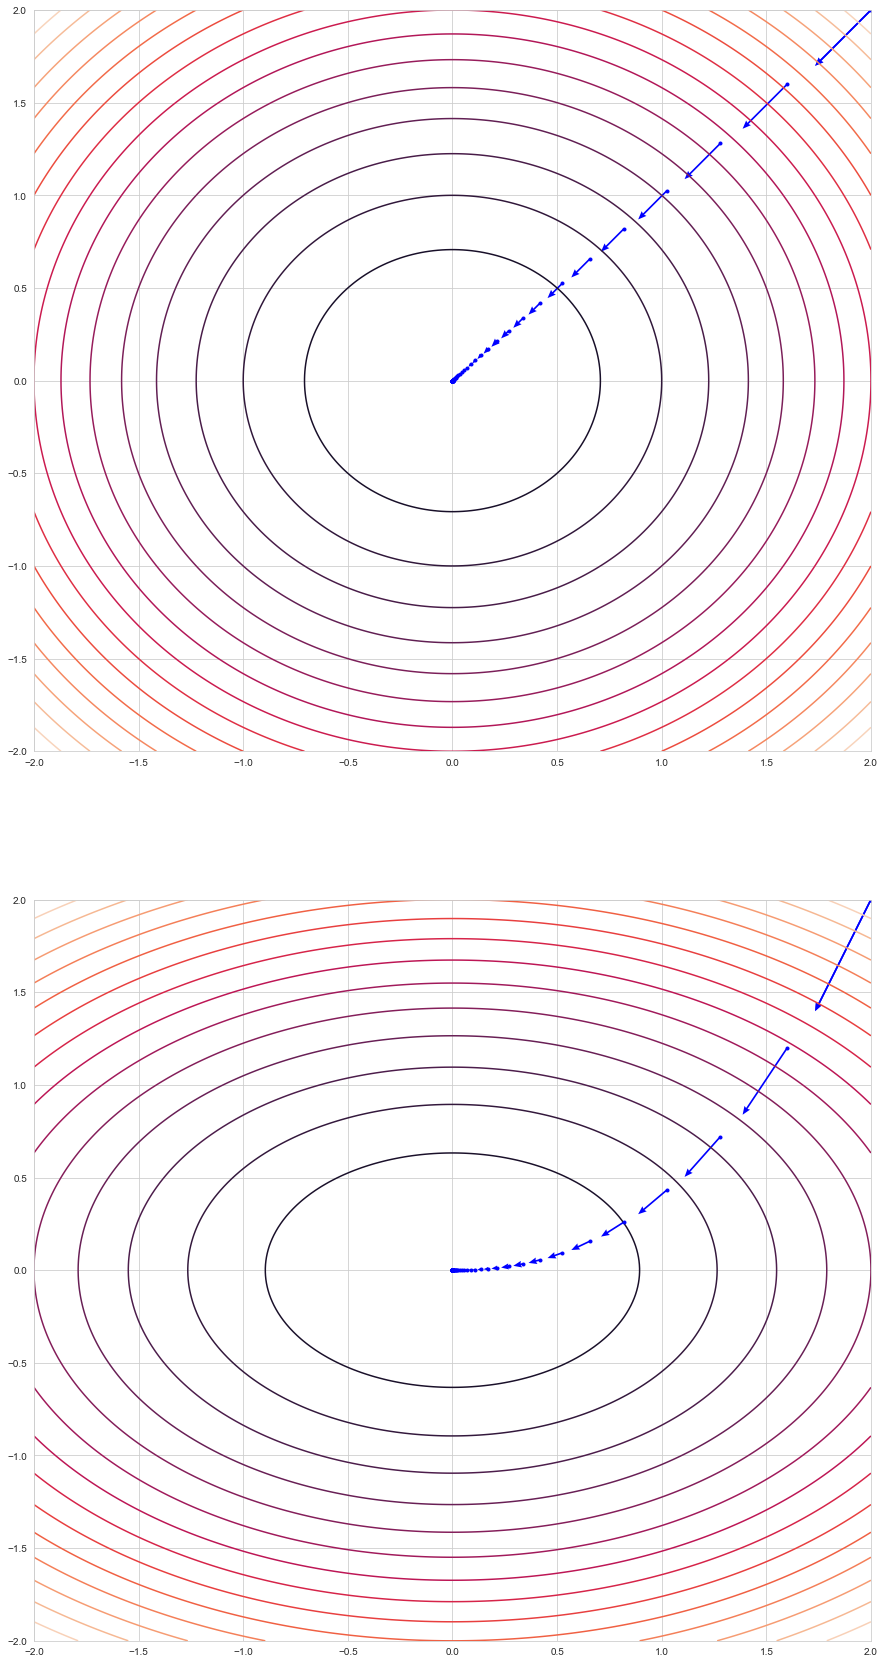

In [57]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
## Plotting level curves for extreme cases
extreme_cases = [gammas[0], gammas[-1]]
for i in range(len(extreme_cases)):
    ax[i].set_xlim(x_mi, x_ma)
    ax[i].set_ylim(y_mi, y_ma)
    ax[i].contour(X, Y, test_list_d2[0].value(x_y, gammas[i]).reshape(nb_pts, -1), 15)
    ax[i].quiver(GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 0], 
                 GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 1],
                 color='b', scale=6, width=0.002, headwidth=4, headlength=5)
    ax[i].plot(GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
               GD_ri_2.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1],
               'b.')

In [58]:
GD_ri_1 = pd.DataFrame(columns=["gamma", "rate", "optimal_pt", "optimal_val", "nb_iter", "iters", "iters_dir"])
GD_list_1 = {}
for t_function in test_list_d2:
    for gamma in gammas:
        GD_list_1[t_function.name] = GD(ddir = dsgd, 
                                        rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.1)
        opt_pt, iters, iters_dir, n_iter = GD_list_1[t_function.name](init_pt_d2, 
                                                     (lambda x: t_function.value (x, gamma)), 
                                                     (lambda x, f, tol : t_function.grad(x, gamma)))
        naming_format = "{}_{}".format(t_function.name, gamma)
        GD_ri_1.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                                 "rate" : 0.01,
                                                 "optimal_pt": opt_pt,
                                                 "optimal_val": t_function.value(opt_pt, gamma),
                                                 "nb_iter": n_iter,
                                                 "iters": iters,
                                                 "iters_dir": iters_dir})
GD_ri_1.loc[:, "gamma": "nb_iter"]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Decay didn't get under tolerance rate.


,gamma,rate,optimal_pt,optimal_val,nb_iter
quadric_2_1.0,1.0,0.01,"[[3.2910091146424137e-07, 3.2910091146424137e-...",[2.1661481985318886e-13],140
quadric_2_2.0,2.0,0.01,"[[3.2910091146424137e-07, 1.591732221989278e-07]]",[1.589796392569729e-13],102
quadric_2_3.0,3.0,0.01,"[[4.113761393303017e-07, 5.4975581388799866e-08]]",[1.7829727165741348e-13],88
quadric_2_4.0,4.0,0.01,"[[4.113761393303017e-07, 4.095999999999986e-08]]",[1.7594121441030375e-13],80
quadric_2_5.0,5.0,0.01,"[[4.113761393303017e-07, 0.0]]",[1.692303280103038e-13],70
quadric_2_6.0,6.0,0.01,"[[4.113761393303017e-07, -4.096000000000023e-08]]",[1.792966576103039e-13],80
quadric_2_7.0,7.0,0.01,"[[3.2910091146424137e-07, 2.1990232555520095e-...",[1.1169240222151542e-13],90
quadric_2_8.0,8.0,0.01,"[[4.113761393303017e-07, -3.4381415994968646e-...",[1.7868698213685648e-13],104
quadric_2_9.0,9.0,0.01,"[[3.2910091146424137e-07, 3.533694129556809e-08]]",[1.1954570470773225e-13],150
quadric_2_10.0,10.0,0.01,"[[2.0, 2.0]]",[44.0],1000


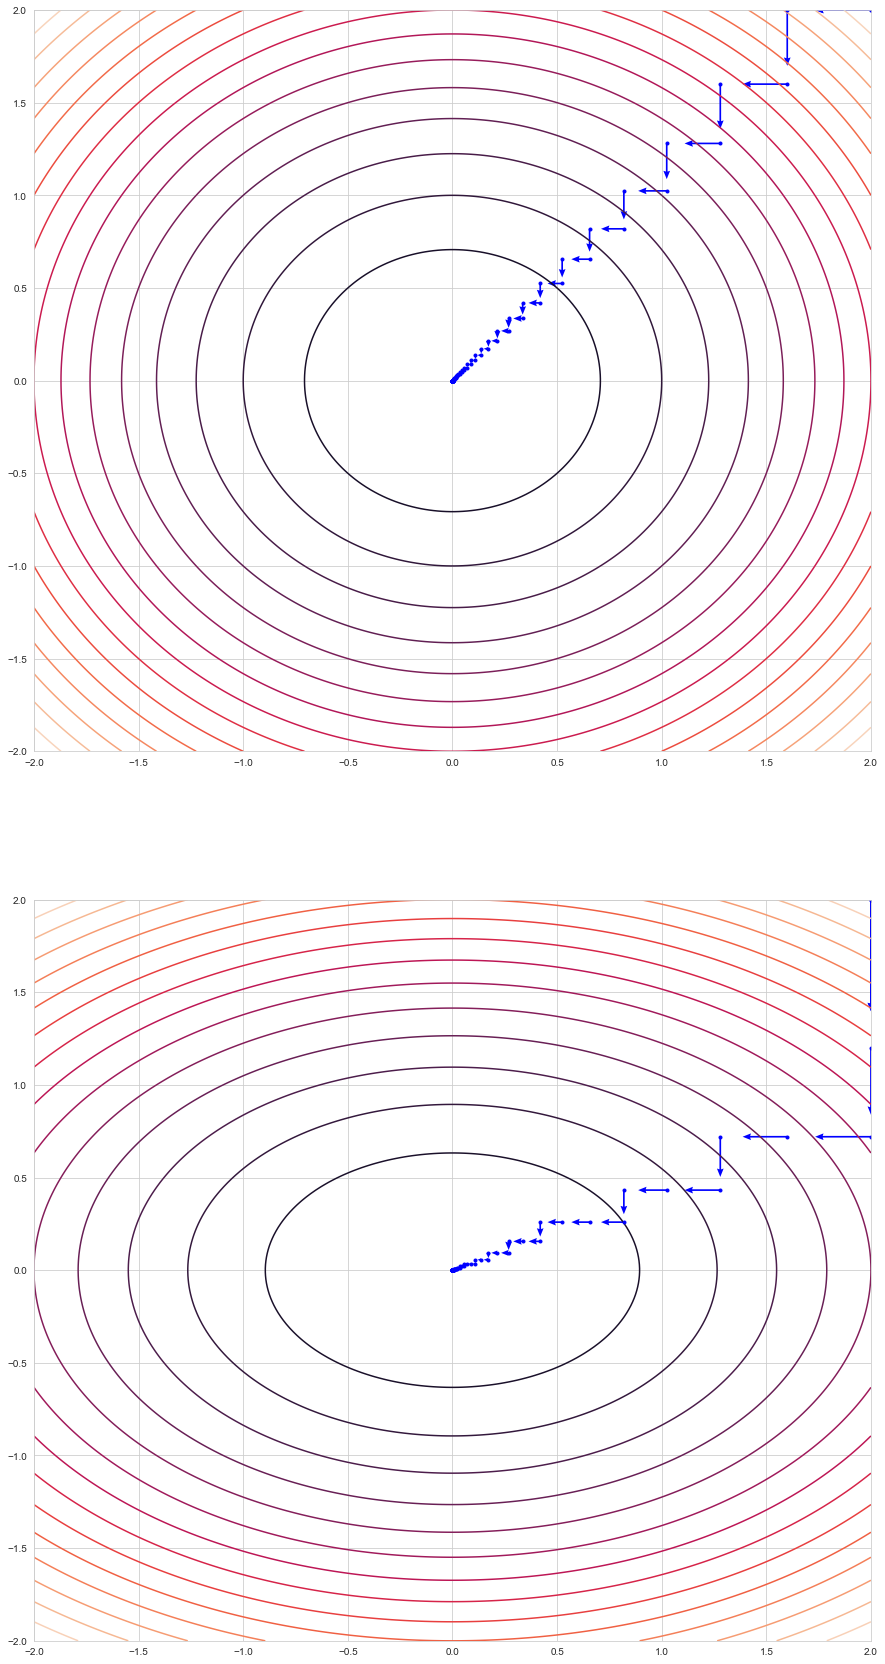

In [59]:
nb_pts, x_mi, x_ma, y_mi, y_ma = 200, -2, 2, -2, 2
fig, ax = plt.subplots(2, 1, figsize=(15, 30))
x, y = np.linspace(x_mi, x_ma, nb_pts), np.linspace(x_mi, x_ma, nb_pts)
X, Y = np.meshgrid(x, y)
## Reshaping X, Y for proper evaluation by input function
x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(1, 2, -1)
## Plotting level curves for extreme cases
extreme_cases = [gammas[0], gammas[-1]]
for i in range(len(extreme_cases)):
    ax[i].set_xlim(x_mi, x_ma)
    ax[i].set_ylim(y_mi, y_ma)
    ax[i].contour(X, Y, test_list_d2[0].value(x_y, gammas[i]).reshape(nb_pts, -1), 15)
    ax[i].quiver(GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
                 GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1], 
                 GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 0], 
                 GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters_dir"][:, 1],
                 color='b', scale=6, width=0.002, headwidth=4, headlength=5)
    ax[i].plot(GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 0], 
               GD_ri_1.loc["quadric_2_{}".format(gammas[i]), "iters"][:, 1],
               'b.')

On en vient désormais à comparer ces deux algos. Vu que les mise-à-jour internes semble demander le même nombre d'itérations il est raisonnable de s'intéresser en premier temps au nombre d'itérations.

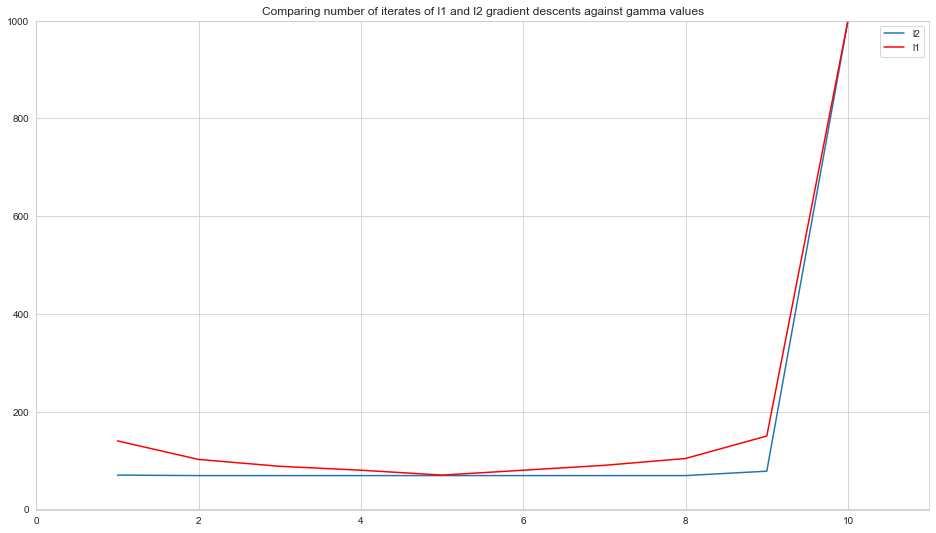

In [60]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_xlim(0, 11)
ax.set_ylim(-1, 1000)
ax.plot(GD_ri_2["gamma"], GD_ri_2["nb_iter"], label="l2")
ax.plot(GD_ri_1["gamma"], GD_ri_1["nb_iter"], "r", label="l1")
ax.set_title("Comparing number of iterates of l1 and l2 gradient descents against gamma values")
ax.legend()

## Sensibilité de GD aux conditionnements de la hessienne

On s'intéresse dans cette section au comportement de la descente de gradients vis-à-vis de la géométrie locale de l'itéré courant. Cette étude va vous permettre de comprendre en quoi le manque de symétrie locale des fonctions objectifs rend plus lente la convergence de la descente de gradient.

1. En utilisant la GD classique à pas constant tracer dans les cas de nombres de conditionnements qui ne dépendent que des paramètres de vos familles tests ce nombre contre le nombre d'itérations de la GD.

                   gamma   init_pt  \
quadric_2_0_1.0      1.0  [[1, 1]]   
quadric_2_1_12.0    12.0  [[1, 1]]   
quadric_2_2_23.0    23.0  [[1, 1]]   
quadric_2_3_34.0    34.0  [[1, 1]]   
quadric_2_4_45.0    45.0  [[1, 1]]   
quadric_2_5_56.0    56.0  [[1, 1]]   
quadric_2_6_67.0    67.0  [[1, 1]]   
quadric_2_7_78.0    78.0  [[1, 1]]   
quadric_2_8_89.0    89.0  [[1, 1]]   
quadric_2_9_100.0  100.0  [[1, 1]]   

                                                          optimal_pt  \
quadric_2_0_1.0     [[3.486516378168841e-07, 3.486516378168841e-07]]   
quadric_2_1_12.0   [[4.915281814827202e-07, 2.0182401885624077e-86]]   
quadric_2_2_23.0   [[4.915281814827202e-07, 3.9004374055909268e-1...   
quadric_2_3_34.0                      [[4.915281814827202e-07, 0.0]]   
quadric_2_4_45.0                      [[4.915281814827202e-07, 0.0]]   
quadric_2_5_56.0                      [[4.915281814827202e-07, 0.0]]   
quadric_2_6_67.0                      [[4.915281814827202e-07, 0.0]]   
quadr

<ipython-input-27-3c425b523369>:80: RuntimeWarning: Decay didn't get under tolerance rate.
  warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)


(1.0, 100.0)

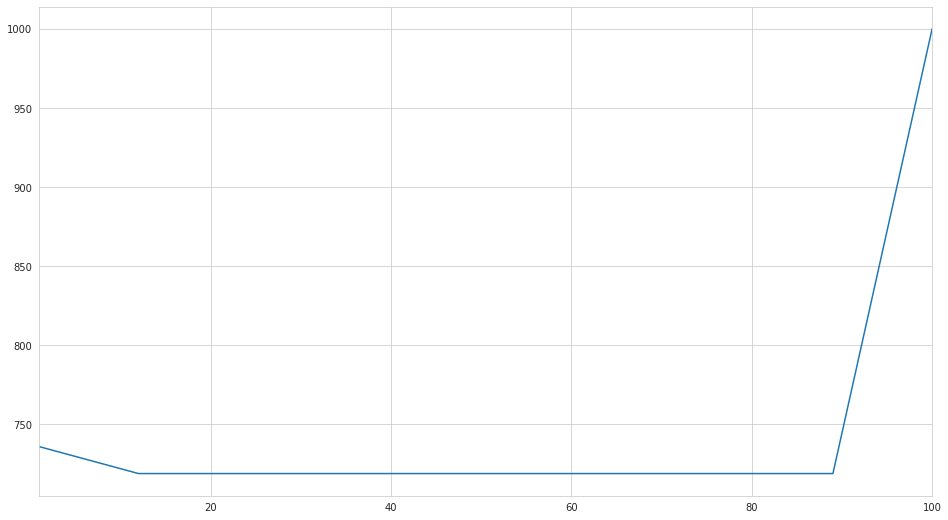

In [61]:
GD_ri = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "optimal_val", "nb_iter"])
GD_list = {}
t_function = quad_II
init_pt = np.array([[1, 1]])
gammas = np.linspace(1, 100, 10)
idt = 0
for gamma in gammas:
    GD_list[t_function.name] = GD()
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                    (lambda x: t_function.value (x, gamma)), 
                                                    (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}_{}".format(t_function.name, idt, gamma)
    GD_ri.loc[naming_format] = pd.Series({"gamma": gamma, 
                                                 "init_pt": init_pt, 
                                                 "optimal_pt": opt_pt,
                                                 "optimal_val": t_function.value(opt_pt, gamma),
                                                 "nb_iter": n_iter})
    idt += 1
print(GD_ri)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(GD_ri["gamma"], GD_ri["nb_iter"])
ax.set_xlim(1, 100)

2. Faire de même avec le cas de *backtracking*

                    gamma   init_pt  \
quadric_2_10_1.0      1.0  [[1, 1]]   
quadric_2_11_12.0    12.0  [[1, 1]]   
quadric_2_12_23.0    23.0  [[1, 1]]   
quadric_2_13_34.0    34.0  [[1, 1]]   
quadric_2_14_45.0    45.0  [[1, 1]]   
quadric_2_15_56.0    56.0  [[1, 1]]   
quadric_2_16_67.0    67.0  [[1, 1]]   
quadric_2_17_78.0    78.0  [[1, 1]]   
quadric_2_18_89.0    89.0  [[1, 1]]   
quadric_2_19_100.0  100.0  [[1, 1]]   

                                                           optimal_pt  \
quadric_2_10_1.0    [[2.2107391972073433e-07, 2.2107391972073433e-...   
quadric_2_11_12.0   [[9.349367714418791e-08, 2.8554876702286392e-08]]   
quadric_2_12_23.0   [[8.464093453235896e-08, 1.6858372698595086e-08]]   
quadric_2_13_34.0   [[1.9820010162602533e-07, -1.2870121182840943e...   
quadric_2_14_45.0    [[8.781806969271964e-08, 8.687325457044646e-09]]   
quadric_2_15_56.0    [[8.028418413158475e-08, 6.792736037985734e-09]]   
quadric_2_16_67.0   [[2.0271433320123458e-07, 6.50512998395

(1.0, 100.0)

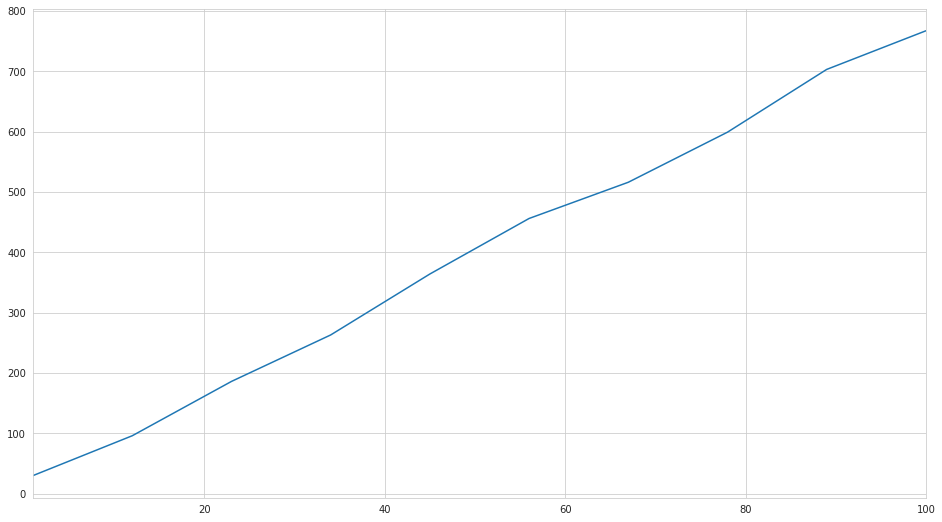

In [62]:
bt_rate = backtracking()
init_pt = np.array([[1, 1]])
gammas = np.linspace(1, 100, 10)
GD_backtr = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "optimal_val", "nb_iter"])
GD_list_ri_bt_2 = {}
for gamma in gammas:
    GD_list_ri_bt_2[quad_II.name] = GD(rate = bt_rate)
    opt_pt, _, _, n_iter = GD_list_ri_bt_2[quad_II.name](init_pt, 
                                                       (lambda x: quad_II.value (x, gamma)), 
                                                       (lambda x, f, tol : quad_II.grad(x, gamma)))
    naming_format = "{}_{}_{}".format(quad_II.name, idt, gamma)
    GD_backtr.loc[naming_format] = pd.Series({"gamma": gamma, 
                                                 "init_pt": init_pt, 
                                                 "optimal_pt": opt_pt,
                                                 "optimal_val": quad_II.value(opt_pt, gamma),
                                                 "nb_iter": n_iter})
    idt += 1
print(GD_backtr)
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(GD_backtr["gamma"], GD_backtr["nb_iter"])
ax.set_xlim(1, 100)

3. Que constatez-vous?

Nous pouvons constater que le nombre de conditionnement de la hessienne, avec une descente descente gradient simple, n'a pas d'impact sur le nombre d'itérations.
Cependant, lors d'une descente de gradient avec la méthode backtracking, nous pouvons observer que le nombre de conditionnement de la hessienne à un impact important sur le nombre d'itérations.

## Accélérations

Il y a des stratégies standards d'accélération de descente de gradients ; on en invente même tous les ans. Il n'y a pas nécessairement de relation d'ordre entre celles-ci, certaines sont plus adaptées que d'autres à des problèmes spécifiques et inversement. On propose d'en implémenter $3$ ici, il s'agit en particulier d'un travail bibliographique (simple).

1. Implémenter la *Momentum Optimisation*. Cherchez à en comprendre le sens.

In [63]:
class Momentum():
    """Momentum Gradient Descent Object.
    """    
    def __init__(self, beta=0.9, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a Moemntum GD object.
        0.9 is the optimal value for Momentum
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
        self.beta = beta if beta else 0.9
    
    def __call__(self, x, f, grad, verbose=False):
        """
        Calling gradient descent with momentum            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            
            # Optimum use here
            delta_x = rate_ * dir_x + self.beta * delta_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

In [64]:
GD_mmt = pd.DataFrame(columns=["gamma", "optimal_pt", "nb_iter"])
GD_list = {}
gamma = 4
for t_function in test_list:
    init_pt = np.array([[1] * t_function.dim])
    GD_list[t_function.name] = Momentum(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                    (lambda x: t_function.value (x, gamma)), 
                                                    (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, gamma)
    GD_mmt.loc[naming_format] = pd.Series({ "gamma": gamma, 
                                                "optimal_pt": opt_pt,
                                                "nb_iter": n_iter })
GD_mmt

<ipython-input-9-d9ef7a3edb7b>:7: RuntimeWarning: overflow encountered in exp
  "grad"  : (lambda x, gamma: gamma*(np.exp(gamma*x) - np.exp(-gamma*x))),
<ipython-input-63-49b933ec9bec>:36: RuntimeWarning: invalid value encountered in add
  delta_x = rate_ * dir_x + self.beta * delta_x


,gamma,optimal_pt,nb_iter
quadratic_1_4,4,[[-0.12499997395270133]],213
cubic_1_4,4,[[-0.13148297748608362]],261
exp_1_4,4,[[nan]],4
multi_sinks_1_4,4,[[-6.216536656251294e-08]],252
quadric_2_4,4,"[[-3.623895474410297e-07, -7.999370431162364e-...",246
quadric_3_4,4,"[[-7.810991762559063e-09, -4.097429151528215e-...",268
quadric_4_4,4,"[[-7.810991762559063e-09, -4.097429151528215e-...",268


En utilisant l'optimisation du **momentum** on retient la direction de l'itération précédente pour calculer la nouvelle direction, cette inertie permet de converger plus vite dans les cas ou il y a des petits extremum locaux. 

2. Implémenter la *Nesterov Optimisation*. Cherchez à en comprendre le sens.

In [65]:
class Nesterov():
    """Nesterov Accelerated Gradient Descent Object.
    """    
    def __init__(self, beta=None, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a NAGD object.
        0.9 is the optimal value for Momentum
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
        self.beta = beta if beta else 0.9
    
    def __call__(self, x, f, grad, verbose=False):
        """
        Calling gradient descent with momentum            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0
        
        y_prev = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x = rate_ * dir_x
            
            # Optimum use here
            y = x + rate_ * dir_x
            x = y + self.beta * (y - y_prev)
            y_prev = y
            
            # Storing iterates
            iters = np.vstack([iters, x])            
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

In [66]:
GD_ri = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "nb_iter"])
GD_list = {}
gamma = 4
for t_function in test_list:
    init_pt = np.array([[1] * t_function.dim])
    GD_list[t_function.name] = Nesterov(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                        (lambda x: t_function.value (x, gamma)), 
                                                        (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, gamma)
    GD_ri.loc[naming_format] = pd.Series({  "gamma": gamma,
                                            "init_pt": init_pt,
                                            "optimal_pt": opt_pt,
                                            "nb_iter": n_iter })

GD_ri

<ipython-input-9-d9ef7a3edb7b>:7: RuntimeWarning: overflow encountered in exp
  "grad"  : (lambda x, gamma: gamma*(np.exp(gamma*x) - np.exp(-gamma*x))),
<ipython-input-65-82238dca7745>:39: RuntimeWarning: invalid value encountered in add
  y = x + rate_ * dir_x


,gamma,init_pt,optimal_pt,nb_iter
quadratic_1_4,4,[[1]],[[-0.12499992661463323]],155
cubic_1_4,4,[[1]],[[-0.131483021558798]],163
exp_1_4,4,[[1]],[[nan]],4
multi_sinks_1_4,4,[[1]],[[6.412477948380679e-08]],146
quadric_2_4,4,"[[1, 1]]","[[-4.814731614618913e-07, -5.806323686938328e-...",236
quadric_3_4,4,"[[1, 1, 1]]","[[-1.0824188273474567e-07, -6.332066811802026e...",237
quadric_4_4,4,"[[1, 1, 1, 1]]","[[-1.0824188273474567e-07, -6.332066811802026e...",237


Le principe de **Nesterov** est le meme que celui du **momentum**, excepté que lors du calcul du momentum, on ajoute la nouvelle direction - l'ancienne direction, ce qui permet de converger plus rapidement vers le point optimal.
![image](https://calculus.subwiki.org/w/images/math/6/c/6/6c6940a2df7ac176b5e960d9b3bbdc35.png)

3. Implémenter la *Adam Optimisation*. Cherchez à en comprendre le sens.

In [67]:
class Adam():
    """Adam Gradient Descent Object.
    """    
    def __init__(self, beta_1=None, beta_2=None, epsilon=None, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a Adam GD object.
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
        self.beta_1 = beta_1 if beta_1 else 0.9
        self.beta_2 = beta_2 if beta_2 else 0.999
        self.epsilon = epsilon if epsilon else 1e-8
    
    def __call__(self, x, f, grad, verbose=False):
        """
        Calling ADAM gradient descent           
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0
        
        t = 1
        m = 0
        v = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            
            # Optinization here
            m = self.beta_1 * m + (1 - self.beta_1) * dir_x
            v = self.beta_2 * v + (1 - self.beta_2) * dir_x * dir_x
            
            # Bias correction
            m_ = m / (1 - self.beta_1**t)
            v_ = v / (1 - self.beta_2**t)
            
            delta_x = rate_ * m_ / (np.sqrt(v_) + self.epsilon)
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            t += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

In [68]:
GD_ri = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "nb_iter"])
GD_list = {}
for t_function in test_list:
    init_pt = np.array([[1] * t_function.dim])
    GD_list[t_function.name] = Adam(rate = lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                        (lambda x: t_function.value (x, gamma)), 
                                                        (lambda x, f, tol : t_function.grad(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, gamma)
    GD_ri.loc[naming_format] = pd.Series({  "gamma": gamma,
                                            "init_pt": init_pt,
                                            "optimal_pt": opt_pt,
                                            "nb_iter": n_iter })

GD_ri

<ipython-input-67-6b1dbc7f8072>:67: RuntimeWarning: Decay didn't get under tolerance rate.
  warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)


,gamma,init_pt,optimal_pt,nb_iter
quadratic_1_4,4,[[1]],[[-0.12499989586569268]],451
cubic_1_4,4,[[1]],[[-0.13148277201073952]],619
exp_1_4,4,[[1]],[[1.1624278949798169e-05]],1000
multi_sinks_1_4,4,[[1]],[[-1.0809621618837828e-07]],427
quadric_2_4,4,"[[1, 1]]","[[-9.64872016853838e-09, -9.650683035776845e-09]]",353
quadric_3_4,4,"[[1, 1, 1]]","[[-9.64872016853838e-09, -9.650683035776845e-0...",353
quadric_4_4,4,"[[1, 1, 1, 1]]","[[-9.64872016853838e-09, -9.650683035776845e-0...",353


L'optimisation **Adam** est une combinaison des meilleurs partie des optimisations **AdaGrad** et **RMSProp**. On choisit toujours un taux d'apprentissage commun, mais celui-ci est multiplié par les éléments du vecteur gradient. Il utilise également les moyennes des premier et second moment du gradient (la moyenne et la variance). Cette optimisation permet d'améliorer les performances dans le cas des gradients avec beaucoup de zéro.

4. Comparer les descentes de gradient pour chacune des optimisations précédentes.

En regardant les différents résultats obtenus avec ses 3 optimizers.

On peut les classer dans cet ordre:
1. Nesterov
2. Momentum
3. Adam

## Méthode de Newton

1. Implémenter la méthode de Newton.

In [69]:
from numpy.linalg import inv

class Newton():
    """
    Newton Gradient Descent Object.
    """ 
    def __init__(self, tol=None, max_iter=None):
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
        
    def __call__(self, x, f, dim, grad, hess, verbose=False):
        """
        Calling Newton gradient descent           
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        if dim > 1:
            delta_x = (-inv(hess(x)) @ grad(x).T).T
        else:
            delta_x = - grad(x) / hess(x)
        iters, iters_dir = x, delta_x
        decay_x = delta_x.dot(-grad(x).T)
        while decay_x > self.tol and n_iter < self.max_iter:
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating with Newton Method's
            if dim > 1:
                delta_x = (-inv(hess(x)) @ grad(x).T).T
            else:
                delta_x = - grad(x) / hess(x)
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = delta_x @ -grad(x).T
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter) 

2. Qu'est-ce qu'un exemple pertinent pour comparer la méthode de Newton au méthode de descente vu précédemment?

La méthode de Newton est une méthode de résolution de l'équation $f(x) = 0$. Si on applique cela a $f'(x)=0$. Cela nous permet de trouver des minimums ou maximums globaux. On va donc s'en servir dans des cas ou les fonctions sont uniquement convexes

3. Comparer la méthode de Newton aux descentes précédentes.

In [70]:
GD_ri = pd.DataFrame(columns=["gamma", "init_pt", "optimal_pt", "nb_iter"])
GD_list = {}
for t_function in test_list:
    init_pt = np.array([[1] * t_function.dim])
    GD_list[t_function.name] = Newton()
    opt_pt, _, _, n_iter = GD_list[t_function.name](init_pt, 
                                                    (lambda x: t_function.value (x, gamma)),
                                                    t_function.dim,
                                                    (lambda x: t_function.grad(x, gamma)),
                                                    (lambda x: t_function.hess(x, gamma)))
    naming_format = "{}_{}".format(t_function.name, gamma)
    GD_ri.loc[naming_format] = pd.Series({  "gamma": gamma,
                                            "init_pt": init_pt,
                                            "optimal_pt": opt_pt,
                                            "nb_iter": n_iter })

GD_ri

,gamma,init_pt,optimal_pt,nb_iter
quadratic_1_4,4,[[1]],[[-0.125]],1
cubic_1_4,4,[[1]],[[-0.13148287902746614]],4
exp_1_4,4,[[1]],[[1.7023020001429023e-08]],6
multi_sinks_1_4,4,[[1]],[[-0.035264404953536665]],1
quadric_2_4,4,"[[1, 1]]","[[0.0, 0.0]]",1
quadric_3_4,4,"[[1, 1, 1]]","[[0.0, 0.0, 0.0]]",1
quadric_4_4,4,"[[1, 1, 1, 1]]","[[0.0, 0.0, 0.0, 0.0]]",1


La methode de Newton est drastiquement plus efficace pour trouver les points optimaux que les techniques précédentes.

## Cas pratique : la régression (YAT)

Dans cette section on attend de vous que vous implémtentier une régression linéaire (puis polynomiale) à la main. Il revient à vous d'effectuer l'étude bibliographique (ou de revoir les documents à votre disposition dans le cours et / ou mon git) pour éventuellement vous aider. À vous de pousser cette étude là où vous souhaitez ; j'attends de vous que vous puissiez entrevoir le besoin de régularisation, sujet abordé en second TP.